#### Importing Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score



#### Importing Dataset


In [12]:
dengue_data = pd.read_csv('dataset/dataset.csv')

#### All combinations of strategies, test sizes, and random states

In [13]:
# Define missing value handling strategies
missing_value_strategies = {
    'constant_0': SimpleImputer(strategy='constant', fill_value=0),
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'mode': SimpleImputer(strategy='most_frequent'),
    'ffill': 'ffill',
    'bfill': 'bfill'
}

# Test sizes and random states
test_sizes = [0.2, 0.25]
random_states = [0, 42]

# To track the best combination
best_combination = None
best_mse = np.inf
best_r2 = -np.inf

# To store results
results = []

# Iterate through all combinations of strategies, test sizes, and random states
for strategy_name, strategy in missing_value_strategies.items():
    # Prepare a copy of the dataset
    data = dengue_data.copy()

    # Handle missing values
    if strategy_name in ['ffill', 'bfill']:
        if strategy_name == 'ffill':
            data.ffill(inplace=True)
        else:
            data.bfill(inplace=True)
        # data.fillna(method=strategy_name, inplace=True)
    else:
        data.iloc[:, 2:] = strategy.fit_transform(data.iloc[:, 2:])

    # Encode categorical data
    label_encoder = LabelEncoder()
    data['District'] = label_encoder.fit_transform(data['District'])

    # Create the target variable for July to November
    data['Target_July_to_November'] = data[['July', 'August', 'September', 'October', 'November']].sum(axis=1)

    # Create lag features
    data['Previous_Year_July_to_November'] = data.groupby('District')[
        ['July', 'August', 'September', 'October', 'November']
    ].shift(1).sum(axis=1).fillna(0)

    # Define features and target
    features = data.drop(columns=[
        'January', 'February', 'March', 'April', 'May', 'June', 'December',
        'July', 'August', 'September', 'October', 'November', 'Target_July_to_November'
    ])
    features['Previous_Year_July_to_November'] = data['Previous_Year_July_to_November']
    target = data['Target_July_to_November']

    # Handle any remaining missing values
    features = features.fillna(0)
    target = target.fillna(0)

    # Try different train-test splits
    for test_size in test_sizes:
        for random_state in random_states:
            # Split data
            X_train, X_test, y_train, y_test = train_test_split(
                features, target, test_size=test_size, random_state=random_state
            )

            # Train the model
            model = GradientBoostingRegressor(random_state=0)
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Save results
            results.append({
                'Strategy': strategy_name,
                'Test_Size': test_size,
                'Random_State': random_state,
                'MSE': mse,
                'R2': r2
            })

            # Update best combination
            if mse < best_mse or (mse == best_mse and r2 > best_r2):
                best_combination = {
                    'Strategy': strategy_name,
                    'Test_Size': test_size,
                    'Random_State': random_state,
                    'MSE': mse,
                    'R2': r2
                }
                best_mse = mse
                best_r2 = r2

# Results DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by='MSE', inplace=True)

# Display all combinations
print("All combinations evaluated:")
print(results_df)

# Display the best combination
print("\nBest combination:")
print(best_combination)

# Use the best combination to train the final model
data = dengue_data.copy()

All combinations evaluated:
      Strategy  Test_Size  Random_State           MSE        R2
16       ffill       0.20             0  7.124463e+06  0.152404
20       bfill       0.20             0  7.483693e+06  0.110366
0   constant_0       0.20             0  7.588032e+06  0.079865
8       median       0.20             0  7.954530e+06  0.034757
12        mode       0.20             0  8.008706e+06  0.028853
4         mean       0.20             0  8.303766e+06  0.012034
22       bfill       0.25             0  1.833720e+07  0.106868
6         mean       0.25             0  1.882665e+07  0.081238
14        mode       0.25             0  1.892302e+07  0.071405
18       ffill       0.25             0  1.894846e+07  0.074445
10      median       0.25             0  1.968534e+07  0.033630
2   constant_0       0.25             0  2.060840e+07 -0.011301
19       ffill       0.25            42  7.336406e+07  0.387836
23       bfill       0.25            42  7.670651e+07  0.360849
11      medi

#### Applying the best strategy

In [14]:
strategy_name = best_combination['Strategy']

if strategy_name in ['ffill', 'bfill']:
    if strategy_name == 'ffill':
        data.ffill(inplace=True)
    else:
        data.bfill(inplace=True)
    # data.fillna(method=strategy_name, inplace=True)
else:
    imputer = missing_value_strategies[strategy_name]
    data.iloc[:, 2:] = imputer.fit_transform(data.iloc[:, 2:])


#### Encoding Categorical data

In [15]:
data['District'] = label_encoder.fit_transform(data['District'])
data['Target_July_to_November'] = data[['July', 'August', 'September', 'October', 'November']].sum(axis=1)
data['Previous_Year_July_to_November'] = data.groupby('District')[
    ['July', 'August', 'September', 'October', 'November']
].shift(1).sum(axis=1).fillna(0)

features = data.drop(columns=[
    'January', 'February', 'March', 'April', 'May', 'June', 'December',
    'July', 'August', 'September', 'October', 'November', 'Target_July_to_November'
])
features['Previous_Year_July_to_November'] = data['Previous_Year_July_to_November']
target = data['Target_July_to_November']


#### Spliting data using the best parameters

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=best_combination['Test_Size'], random_state=best_combination['Random_State']
)

#### Feature Scaling


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Model Training and Making Predictions


In [18]:
final_model = GradientBoostingRegressor(random_state=0)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

#### Evaluating the Model

In [19]:
final_mse = mean_squared_error(y_test, y_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, y_pred)
final_cvr = final_rmse / y_test.mean()
final_theil = final_rmse / (y_test.mean() - y_pred.mean())

print("\nFinal model evaluation:Gradient Boosting Regressor")
print(f"R square value: {final_r2}")
print(f"Mean Squared Error: {final_mse}")
print(f"Root Mean Squared Error: {final_rmse}")
print(f"Coefficient of Variation of RMSE: {final_cvr}")
print(f"Theil's U: {final_theil}")



Final model evaluation:Gradient Boosting Regressor
R square value: 0.1524035461191734
Mean Squared Error: 7124463.495973003
Root Mean Squared Error: 2669.169064704033
Coefficient of Variation of RMSE: 1.8390602561134126
Theil's U: -6.500812880108979


#### Visualizing Predictions


<Figure size 1400x800 with 0 Axes>

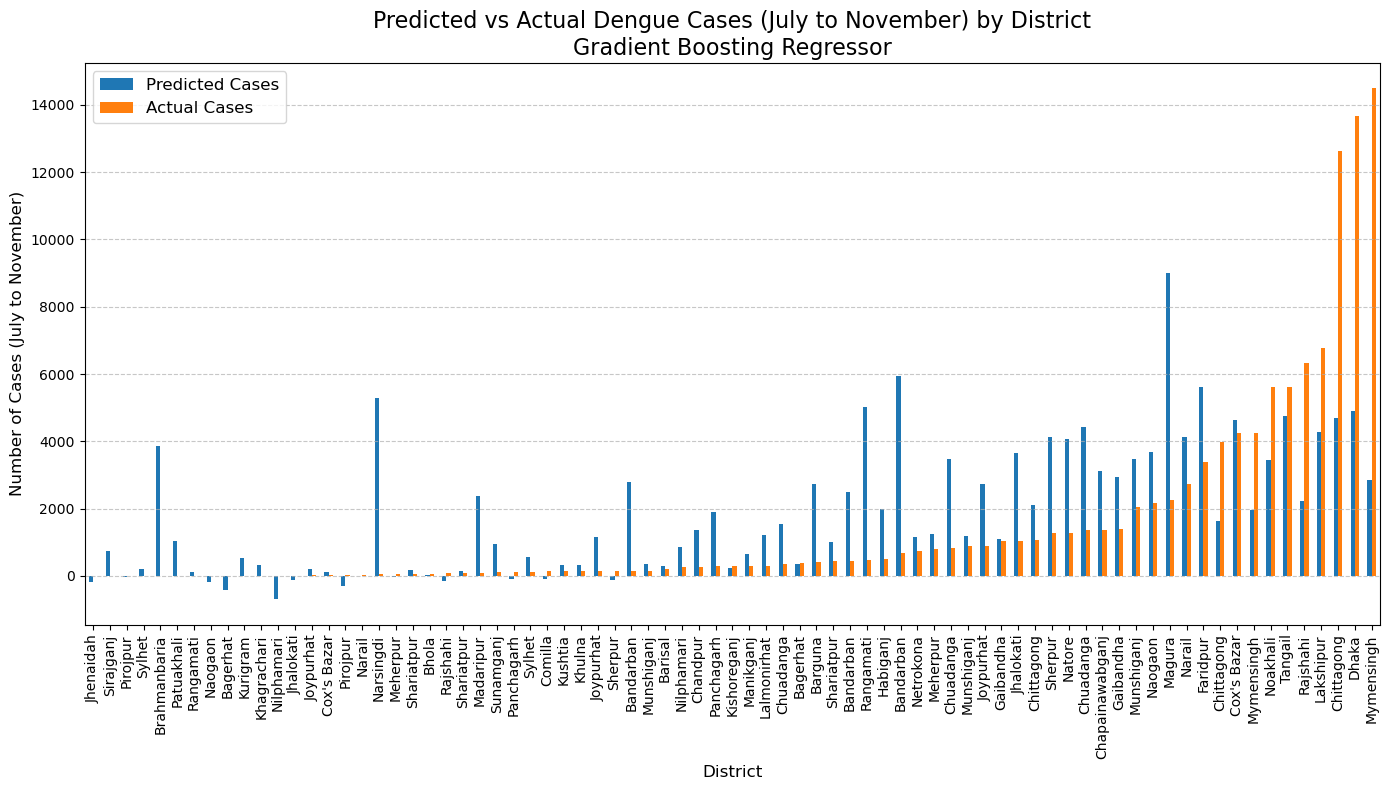

In [20]:
district_predictions = pd.DataFrame({
    'District': X_test['District'],
    'Predicted_Cases': y_pred,
    'Actual_Cases': y_test.values
}).reset_index(drop=True)

# Decode district labels back to their original names
district_predictions['District'] = label_encoder.inverse_transform(district_predictions['District'])

plt.figure(figsize=(14, 8))
district_predictions.sort_values('Actual_Cases').plot(
    kind='bar', x='District', y=['Predicted_Cases', 'Actual_Cases'], figsize=(14, 8)
)
plt.title('Predicted vs Actual Dengue Cases (July to November) by District\nGradient Boosting Regressor', fontsize=16)
plt.xlabel('District', fontsize=12)
plt.ylabel('Number of Cases (July to November)', fontsize=12)
plt.legend(['Predicted Cases', 'Actual Cases'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90)
plt.tight_layout()

plt.savefig('GradientBoostingRegressor.png', bbox_inches='tight', dpi=300)

plt.show()